

---
***VEHICLE ROUTING***

---




**`Capacitated Vehicle Routing Problem`**

In [ ]:
!pip install networkx

In [ ]:
import networkx as nx
import random
class AntColony:
    def __init__(self, graph, num_ants, Q, alpha=1, beta=2, evaporation=0.5):
        self.graph = graph
        self.pheromone = {(i, j): 1 for i, j in graph.edges()}
        self.all_ants = self.generate_ants(num_ants)
        self.Q = Q
        self.alpha = alpha
        self.beta = beta
        self.evaporation = evaporation
    def generate_ants(self, num_ants):
        return [Ant(self) for _ in range(num_ants)]
    def solve(self, iterations):
        for _ in range(iterations):
            self.move_ants()
            self.update_pheromone()
            self.update_best_solution()
    def move_ants(self):
        for ant in self.all_ants:
            ant.move()
    def update_pheromone(self):
        for edge in self.graph.edges():
            pheromone_delta = 0
            for ant in self.all_ants:
                if edge in ant.path or (edge[1], edge[0]) in ant.path:
                    pheromone_delta += self.Q / ant.total_distance()
            self.pheromone[edge] = (1 - self.evaporation) * self.pheromone[edge] + pheromone_delta
    def update_best_solution(self):
        best_ant = min(self.all_ants, key=lambda ant: ant.total_distance())
        if not hasattr(self, 'best_ant') or best_ant.total_distance() < self.best_ant.total_distance():
            self.best_ant = best_ant
class Ant:
    def __init__(self, colony):
        self.colony = colony
        self.path = []
        self.visited = set()
        self.current = random.choice(list(colony.graph.nodes()))
    def move(self):
        for _ in range(len(self.colony.graph.nodes()) - len(self.visited)):
            next_node = self.choose_next()
            self.path.append((self.current, next_node))
            self.visited.add(next_node)
            self.current = next_node
    def choose_next(self):
        pheromone_scores = []
        for neighbor in self.get_neighbors():
            if neighbor not in self.visited:
                pheromone_scores.append((neighbor, self.colony.pheromone.get((self.current, neighbor), 0)))
        total_score = sum(score ** self.colony.alpha * (1 / self.colony.graph[self.current][neighbor]['weight']) ** self.colony.beta for neighbor, score in pheromone_scores)
        if total_score == 0:
            selected_next = random.choice(self.get_neighbors())
        else:
            probabilities = [(neighbor, score ** self.colony.alpha * (1 / self.colony.graph[self.current][neighbor]['weight']) ** self.colony.beta / total_score) for neighbor, score in pheromone_scores]
            selected_next = random.choices(probabilities)[0][0]
        return selected_next
    def total_distance(self):
        total_dist = 0
        for edge in self.path:
            total_dist += self.colony.graph[edge[0]][edge[1]]['weight']
            total_dist += self.colony.graph[edge[1]][edge[0]]['weight']
        return total_dist
    def get_neighbors(self):
        return [neighbor for neighbor in self.colony.graph.neighbors(self.current) if neighbor not in self.visited]
G = nx.complete_graph(5)
for edge in G.edges():
    G[edge[0]][edge[1]]['weight'] = random.randint(1, 10)
colony = AntColony(G, num_ants=5, Q=100, alpha=1, beta=2, evaporation=0.5)
colony.solve(iterations=100)
print("Best Route =", colony.best_ant.path)
print("Total Distance =", colony.best_ant.total_distance())

Best Route = [(0, 4), (4, 2), (2, 1), (1, 0), (0, 3)]
Total Distance = 44


Iteration-0: Best Distance = 9, Best Path = [4, 3, 1, 5, 8, 7, 2, 0, 6, 9]
Final Solution = [4, 3, 1, 5, 8, 7, 2, 0, 6, 9], Final Distance = 9


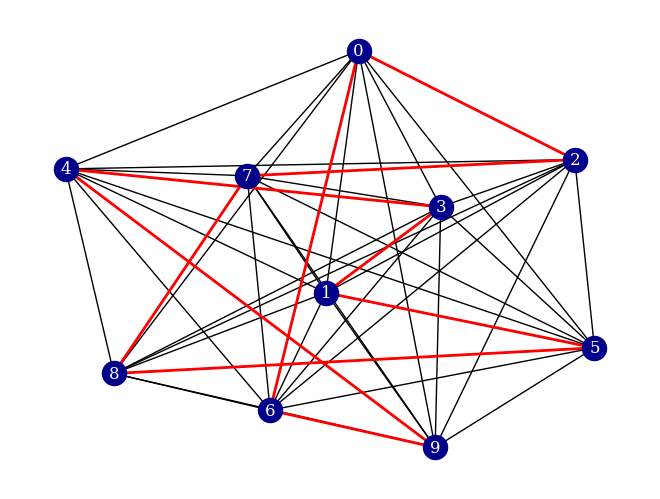

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
class CVRPACO:
    def __init__(self, graph, num_ants, pheromone_evaporation_rate, alpha, beta, Q):
        self.graph = graph
        self.num_ants = num_ants
        self.pheromone_evaporation_rate = pheromone_evaporation_rate
        self.alpha = alpha
        self.beta = beta
        self.Q = Q
        self.nodes = list(graph.nodes)
        self.pheromone = {(i, j): 1.0 for i in self.nodes for j in self.nodes if i != j}
        self.distances = dict(nx.all_pairs_shortest_path_length(graph))
    def get_neighbors(self, current_node, visited_nodes):
        return [node for node in self.nodes if node not in visited_nodes and node != current_node]
    def select_next_node(self, current_node, visited_nodes):
        neighbors = self.get_neighbors(current_node, visited_nodes)
        probabilities = [self.calculate_probability(current_node, neighbor, visited_nodes) for neighbor in neighbors]
        selected_node = np.random.choice(neighbors, p=probabilities)
        return selected_node
    def calculate_probability(self, current_node, next_node, visited_nodes):
        pheromone = self.pheromone[current_node, next_node]
        distance = self.distances[current_node][next_node]
        visibility = 1 / distance if distance > 0 else 0
        total_pheromone = sum(self.pheromone[current_node, neighbor] for neighbor in self.get_neighbors(current_node, visited_nodes))
        probability = (pheromone ** self.alpha) * (visibility ** self.beta) / total_pheromone
        return probability
    def update_pheromone(self, ant_paths):
        for path in ant_paths:
            total_distance = sum(self.distances[path[i]][path[i + 1]] for i in range(len(path) - 1))
            for i in range(len(path) - 1):
                self.pheromone[path[i], path[i + 1]] += self.Q / total_distance
        for edge in self.pheromone:
            self.pheromone[edge] *= (1 - self.pheromone_evaporation_rate)
    def solve(self, max_iterations):
        best_solution = None
        best_distance = float('inf')
        for iteration in range(max_iterations):
            ant_paths = []
            for ant in range(self.num_ants):
                current_node = np.random.choice(self.nodes)
                visited_nodes = [current_node]
                while len(visited_nodes) < len(self.nodes):
                    next_node = self.select_next_node(current_node, visited_nodes)
                    visited_nodes.append(next_node)
                    current_node = next_node
                ant_paths.append(visited_nodes)
            self.update_pheromone(ant_paths)
            if iteration % 10 == 0:
                global_best_path = min(ant_paths, key=lambda path: sum(self.distances[path[i]][path[i + 1]] for i in range(len(path) - 1)))
                global_best_distance = sum(self.distances[global_best_path[i]][global_best_path[i + 1]] for i in range(len(global_best_path) - 1))
                if global_best_distance < best_distance:
                    best_solution = global_best_path
                    best_distance = global_best_distance
                    print(f"Iteration-{iteration}: Best Distance = {best_distance}, Best Path = {best_solution}")
        return best_solution, best_distance
if __name__ == "__main__":
    G = nx.complete_graph(10)
    for edge in G.edges:
        G.edges[edge]['weight'] = np.random.randint(1, 10)
    num_ants = 5
    pheromone_evaporation_rate = 0.2
    alpha = 1
    beta = 2
    Q = 1
    cvrp_aco = CVRPACO(G, num_ants, pheromone_evaporation_rate, alpha, beta, Q)
    solution, distance = cvrp_aco.solve(max_iterations=100)
    print(f"Final Solution = {solution}, Final Distance = {distance}")
def plot_solution(graph, solution):
    pos = nx.spring_layout(graph)
    node_color = 'darkblue'
    font_color = 'white'
    font_family = 'serif'
    nx.draw(graph, pos, with_labels=True, node_color=node_color, font_color=font_color, font_family=font_family)
    edges = [(solution[i], solution[i + 1]) for i in range(len(solution) - 1)]
    edges.append((solution[-1], solution[0]))
    nx.draw_networkx_edges(graph, pos, edgelist=edges, edge_color='r', width=2)
    plt.show()
plot_solution(G, solution)

In [ ]:
import networkx as nx
import numpy as np
import pygraphviz as pgv
from PIL import Image
class CVRPACO:
    def __init__(self, graph, num_ants, pheromone_evaporation_rate, alpha, beta, Q, capacity):
        self.graph = graph
        self.num_ants = num_ants
        self.pheromone_evaporation_rate = pheromone_evaporation_rate
        self.alpha = alpha
        self.beta = beta
        self.Q = Q
        self.capacity = capacity
        self.nodes = list(graph.nodes)
        self.pheromone = {(i, j): 1.0 for i in self.nodes for j in self.nodes if i != j}
        self.distances = dict(nx.all_pairs_shortest_path_length(graph))
    def get_neighbors(self, current_node, visited_nodes):
        return [node for node in self.nodes if node not in visited_nodes and node != current_node]
    def select_next_node(self, current_node, visited_nodes):
        neighbors = self.get_neighbors(current_node, visited_nodes)
        probabilities = [self.calculate_probability(current_node, neighbor, visited_nodes) for neighbor in neighbors]
        selected_node = np.random.choice(neighbors, p=probabilities)
        return selected_node
    def calculate_probability(self, current_node, next_node, visited_nodes):
        pheromone = self.pheromone[current_node, next_node]
        distance = self.distances[current_node][next_node]
        visibility = 1 / distance if distance > 0 else 0
        total_pheromone = sum(self.pheromone[current_node, neighbor] for neighbor in self.get_neighbors(current_node, visited_nodes))
        probability = (pheromone ** self.alpha) * (visibility ** self.beta) / total_pheromone
        return probability
    def update_pheromone(self, ant_paths):
        for path in ant_paths:
            total_distance = sum(self.distances[path[i]][path[i + 1]] for i in range(len(path) - 1))
            for i in range(len(path) - 1):
                self.pheromone[path[i], path[i + 1]] += self.Q / total_distance
        for edge in self.pheromone:
            self.pheromone[edge] *= (1 - self.pheromone_evaporation_rate)
    def solve(self, max_iterations, max_no_improvement):
        best_solution = None
        best_distance = float('inf')
        no_improvement_count = 0
        for iteration in range(max_iterations):
            ant_paths = []
            for ant in range(self.num_ants):
                current_node = np.random.choice(self.nodes)
                visited_nodes = [current_node]
                remaining_capacity = self.capacity
                while len(visited_nodes) < len(self.nodes):
                    next_node = self.select_next_node(current_node, visited_nodes)
                    visited_nodes.append(next_node)
                    remaining_capacity -= self.graph.nodes[next_node]['demand']
                    if remaining_capacity < 0:
                        visited_nodes = [current_node, next_node]
                        remaining_capacity = self.capacity
                    current_node = next_node
                ant_paths.append(visited_nodes)
            self.update_pheromone(ant_paths)
            global_best_path = min(ant_paths, key=lambda path: sum(self.distances[path[i]][path[i + 1]] for i in range(len(path) - 1)))
            global_best_distance = sum(self.distances[global_best_path[i]][global_best_path[i + 1]] for i in range(len(global_best_path) - 1))
            if global_best_distance < best_distance:
                best_solution = global_best_path
                best_distance = global_best_distance
                no_improvement_count = 0
                print(f"Iteration-{iteration}: Best Distance = {best_distance}, Best Path = {best_solution}")
            else:
                no_improvement_count += 1
            if no_improvement_count >= max_no_improvement:
                print(f"Terminating early due to no improvement in {max_no_improvement} consecutive iterations.")
                break
        return best_solution, best_distance
def create_graph(solution, graph):
    G_solution = graph.copy()
    G_solution.add_edges_from([(solution[i], solution[i + 1]) for i in range(len(solution) - 1)])
    G_solution.add_edge(solution[-1], solution[0])
    return G_solution
def visualize_solution(graph, solution, output_path='solution_graph.png'):
    G_solution = create_graph(solution, graph)
    agraph_solution = nx.nx_agraph.to_agraph(G_solution)
    agraph_solution.node_attr['color'] = 'yellow'
    agraph_solution.node_attr['fontcolor'] = 'black'
    agraph_solution.node_attr['fontname'] = 'serif'
    agraph_solution.edge_attr['color'] = 'red'
    agraph_solution.draw(output_path, format='png', prog='dot')
    Image.open(output_path).show()
if __name__ == "__main__":
    G = nx.complete_graph(10)
    for node in G.nodes:
        G.nodes[node]['demand'] = np.random.randint(1, 5)
    for edge in G.edges:
        G.edges[edge]['weight'] = np.random.randint(1, 10)
    num_ants = 5
    pheromone_evaporation_rate = 0.2
    alpha = 1
    beta = 2
    Q = 1
    capacity = 10
    max_no_improvement = 20
    cvrp_aco = CVRPACO(G, num_ants, pheromone_evaporation_rate, alpha, beta, Q, capacity)
    solution, distance = cvrp_aco.solve(max_iterations=500, max_no_improvement=max_no_improvement)
    visualize_solution(G, solution)

In [ ]:
import networkx as nx
import numpy as np
import pygraphviz as pgv
from PIL import Image
class CVRPACO:
    def __init__(self, graph, num_ants, pheromone_evaporation_rate, alpha, beta, Q, capacity):
        self.graph = graph
        self.num_ants = num_ants
        self.pheromone_evaporation_rate = pheromone_evaporation_rate
        self.alpha = alpha
        self.beta = beta
        self.Q = Q
        self.capacity = capacity
        self.nodes = list(graph.nodes)
        self.pheromone = {(i, j): 1.0 for i in self.nodes for j in self.nodes if i != j}
        self.distances = dict(nx.all_pairs_shortest_path_length(graph))
    def get_neighbors(self, current_node, visited_nodes):
        return [node for node in self.nodes if node not in visited_nodes and node != current_node]
    def select_next_node(self, current_node, visited_nodes):
        neighbors = self.get_neighbors(current_node, visited_nodes)
        probabilities = [self.calculate_probability(current_node, neighbor, visited_nodes) for neighbor in neighbors]
        selected_node = np.random.choice(neighbors, p=probabilities)
        return selected_node
    def calculate_probability(self, current_node, next_node, visited_nodes):
        pheromone = self.pheromone[current_node, next_node]
        distance = self.distances[current_node][next_node]
        visibility = 1 / distance if distance > 0 else 0
        total_pheromone = sum(self.pheromone[current_node, neighbor] for neighbor in self.get_neighbors(current_node, visited_nodes))
        probability = (pheromone ** self.alpha) * (visibility ** self.beta) / total_pheromone
        return probability
    def update_pheromone(self, ant_paths):
        for path in ant_paths:
            total_distance = sum(self.distances[path[i]][path[i + 1]] for i in range(len(path) - 1))
            for i in range(len(path) - 1):
                self.pheromone[path[i], path[i + 1]] += self.Q / total_distance
        for edge in self.pheromone:
            self.pheromone[edge] *= (1 - self.pheromone_evaporation_rate)
    def solve(self, max_iterations, max_no_improvement):
        best_solution = None
        best_distance = float('inf')
        no_improvement_count = 0
        for iteration in range(max_iterations):
            ant_paths = []
            for ant in range(self.num_ants):
                current_node = np.random.choice(self.nodes)
                visited_nodes = [current_node]
                remaining_capacity = self.capacity
                while len(visited_nodes) < len(self.nodes):
                    next_node = self.select_next_node(current_node, visited_nodes)
                    visited_nodes.append(next_node)
                    remaining_capacity -= self.graph.nodes[next_node]['demand']
                    if remaining_capacity < 0:
                        visited_nodes = [current_node, next_node]
                        remaining_capacity = self.capacity
                    current_node = next_node
                ant_paths.append(visited_nodes)
            self.update_pheromone(ant_paths)
            global_best_path = min(ant_paths, key=lambda path: sum(self.distances[path[i]][path[i + 1]] for i in range(len(path) - 1)))
            global_best_distance = sum(self.distances[global_best_path[i]][global_best_path[i + 1]] for i in range(len(global_best_path) - 1))
            if global_best_distance < best_distance:
                best_solution = global_best_path
                best_distance = global_best_distance
                no_improvement_count = 0
                print(f"Iteration-{iteration}: Best Distance = {best_distance}, Best Path = {best_solution}")
            else:
                no_improvement_count += 1
            if no_improvement_count >= max_no_improvement:
                print(f"Terminating early due to no improvement in {max_no_improvement} consecutive iterations.")
                break
        return best_solution, best_distance
def create_graph(solution, graph):
    G_solution = graph.copy()
    G_solution.add_edges_from([(solution[i], solution[i + 1]) for i in range(len(solution) - 1)])
    G_solution.add_edge(solution[-1], solution[0])
    return G_solution
def visualize_solution(graph, solution, output_path='solution_graph.png'):
    G_solution = create_graph(solution, graph)
    agraph_solution = nx.nx_agraph.to_agraph(G_solution)
    agraph_solution.node_attr['color'] = 'yellow'
    agraph_solution.node_attr['fontcolor'] = 'black'
    agraph_solution.node_attr['fontname'] = 'serif'
    agraph_solution.edge_attr['color'] = 'red'
    agraph_solution.draw(output_path, format='png', prog='dot')
    Image.open(output_path).show()
if __name__ == "__main__":
    G = nx.complete_graph(10)
    for node in G.nodes:
        G.nodes[node]['demand'] = np.random.randint(1, 5)
    for edge in G.edges:
        G.edges[edge]['weight'] = np.random.randint(1, 10)
    num_ants = 5
    pheromone_evaporation_rate = 0.2
    alpha = 1
    beta = 2
    Q = 1
    capacity = 10
    max_no_improvement = 20
    cvrp_aco = CVRPACO(G, num_ants, pheromone_evaporation_rate, alpha, beta, Q, capacity)
    solution, distance = cvrp_aco.solve(max_iterations=500, max_no_improvement=max_no_improvement)
    visualize_solution(G, solution)